In [5]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression


# Set styles
sns.set(style = "white")

In [6]:
# SUPPORT FUNCTIONS DATA PROCESSING
def collect_datasets(files = ['a', 'b'],
                     burn_in = 1000,
                     sort_ = True):
    dats = []
    for file_ in files:
            dats.append(pickle.load(open(file_ , 'rb')))

    dat_tmp_0 = []
    dat_tmp_1 = []
    for dat in dats:
        dat_tmp_0.append(dat[0])
        dat_tmp_1.append(dat[2])

    dat_total = [np.concatenate(dat_tmp_0, axis = 0), np.concatenate(dat_tmp_1, axis = 0)]


    # Sort by first column in parameters
    if sort_ == True:
        ind = np.argsort(dat_total[0][:, 0])
        dat_total[0] = dat_total[0][ind]
        dat_total[1] = dat_total[1][ind]

    # Calculate posterior means
    means = np.mean(dat_total[1][:, burn_in:, :], axis = (1))
    return (dat_total, means)

def get_r2_vec(estimates = [0, 0, 0],
               ground_truths = [0, 0, 0]):
    
    r2_vec = []
    for i in range(estimates.shape[1]):
        reg = LinearRegression().fit(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T)
        r2_vec.append(str(round(reg.score(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T), 2)))
    return r2_vec

In [7]:
def parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'], 
                            title = 'Parameter Recovery: ABC-NN',
                            ground_truths = [0, 0, 0],
                            estimates = [0, 0, 0],
                            r2_vec = [0, 0, 0],
                            cols = 3):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(estimates.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.regplot(ground_truths[:, i], estimates[:, i], 
                    color = 'black', 
                    marker =  '+',
                    ax = ax[row_tmp, col_tmp],
                    scatter_kws = {'s': 120, 'alpha': 0.5})
        ax[row_tmp, col_tmp].text(0.7, 0.1, '$R^2$: ' + r2_vec[i], 
                                  transform = ax[row_tmp, col_tmp].transAxes, 
                                  fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i] + ' - ground truth', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior mean', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)

    for i in range(estimates.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    return plt.show()


def posterior_variance_hist(var_data = [],
                                       var_data_title = '..',
                                       ax_titles = ['v', 'a', 'w', 'ndt'],
                                       cols = 3):  

    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = True)
    fig.suptitle('Posterior variance: FCN, n - ' + var_data_title, 
                 fontsize = 40)
    sns.despine(right = True)

    #x_title = '$\ln \sigma^2_{' + var_data_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

    for i in range(var_data.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)

        sns.distplot(np.log((var_data[:, i])), 
                     bins = 20,
                     color = 'black',
                     norm_hist = True,
                     kde = False,
                     rug = False,
                     #rug_kws = {"c": grayscale_map(dat_total[0][:, j]), 'alpha': 0.3},
                     ax = ax[row_tmp, col_tmp])

#         ax[row_tmp, col_tmp].set_xlabel(x_title, 
#                                         fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "y",
                                         labelsize = 24)
        ax[row_tmp, col_tmp].set_title(ax_titles[i], 
                                       fontsize = 24)

    for i in range(var_data.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    #plt.show()  

In [8]:
method_comparison_folder = "/media/data_cifs/afengler/data/kde/weibull_cdf/method_comparison/"
file_signature  = 'deep_inference_rep_10'
file_signature_len = len(file_signature)
files = os.listdir(method_comparison_folder)
files = [method_comparison_folder + file_ for file_ in files if file_[:file_signature_len] == file_signature]

In [51]:
dat_total = []
for file_ in files:
    dat_tmp = pickle.load(open(file_, 'rb'))
    tmp = []
    tmp.append(dat_tmp[0][0])
    tmp.append(dat_tmp[1][0])
    tmp.append(dat_tmp[2])
    dat_total.append(tmp)


#dat_total[0][2].shape
cnt = 0
for i in range(len(dat_total)):
    dat_total[i][0] = dat_total[i][0]
    dat_total[i][1] = dat_total[i][1]
    ind = np.argsort(dat_total[i][0][:, 0])
    dat_total[i][0][:] = dat_total[i][0][ind]
    dat_total[i][1][: , :] = dat_total[i][1][ind]
    dat_total[i][2][:] = dat_total[i][2][ind]
    cnt += 1

dat_total_var = []
for i in range(len(dat_total)):
    dat_total_var.append(dat_total[i][2][:, int(dat_total[i][2].shape[1] / 2):])

In [7]:
# FCN
deep_inference_var = fcn_dat_total[2][:, int(fcn_dat_total[2].shape[1] / 2):]

r2_vec_fcn = get_r2_vec(estimates = dat_total_fcn[2][:, :int(dat_total_fcn[2].shape[1] / 2)],
                        ground_truths = dat_total_fcn[0])

NameError: name 'fcn_dat_total' is not defined

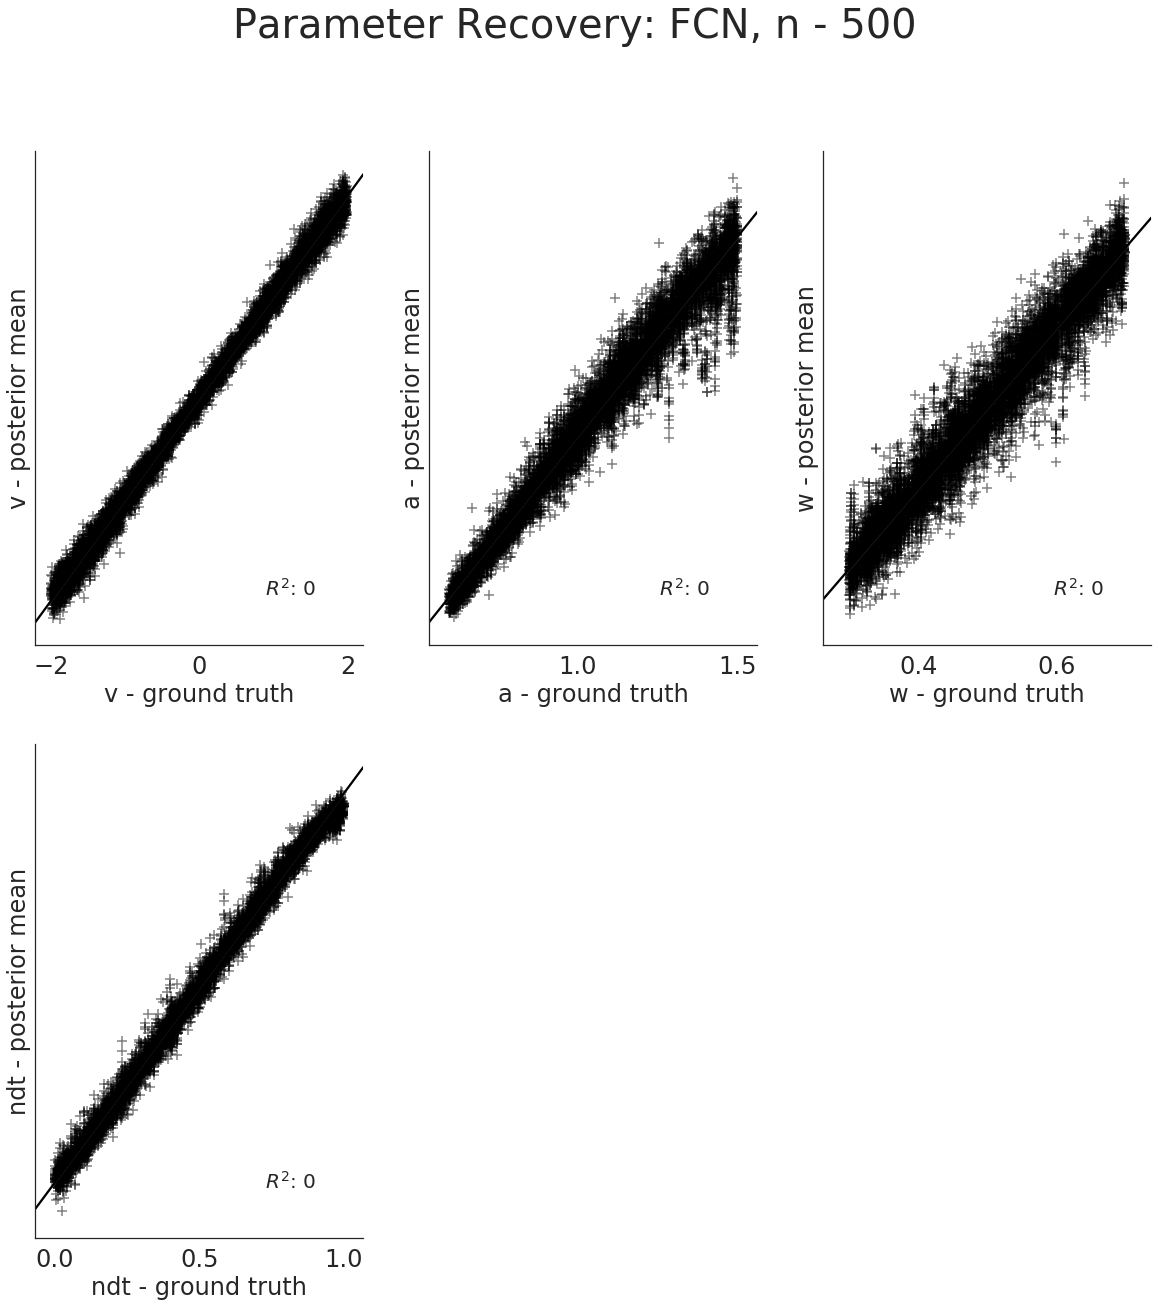

In [62]:
# PARAMETER RECOVERY PLOTS: KDE
i = 0
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt'],
                        title = 'Parameter Recovery: FCN, n - ' + str(dat_total[i][1].shape[1]),
                        ground_truths = dat_total[i][0],
                        estimates = dat_total[i][2][:, :int(dat_total[i][2].shape[1] / 2)],
                        r2_vec = [str(0), str(0), str(0), str(0)],
                        cols = 3)

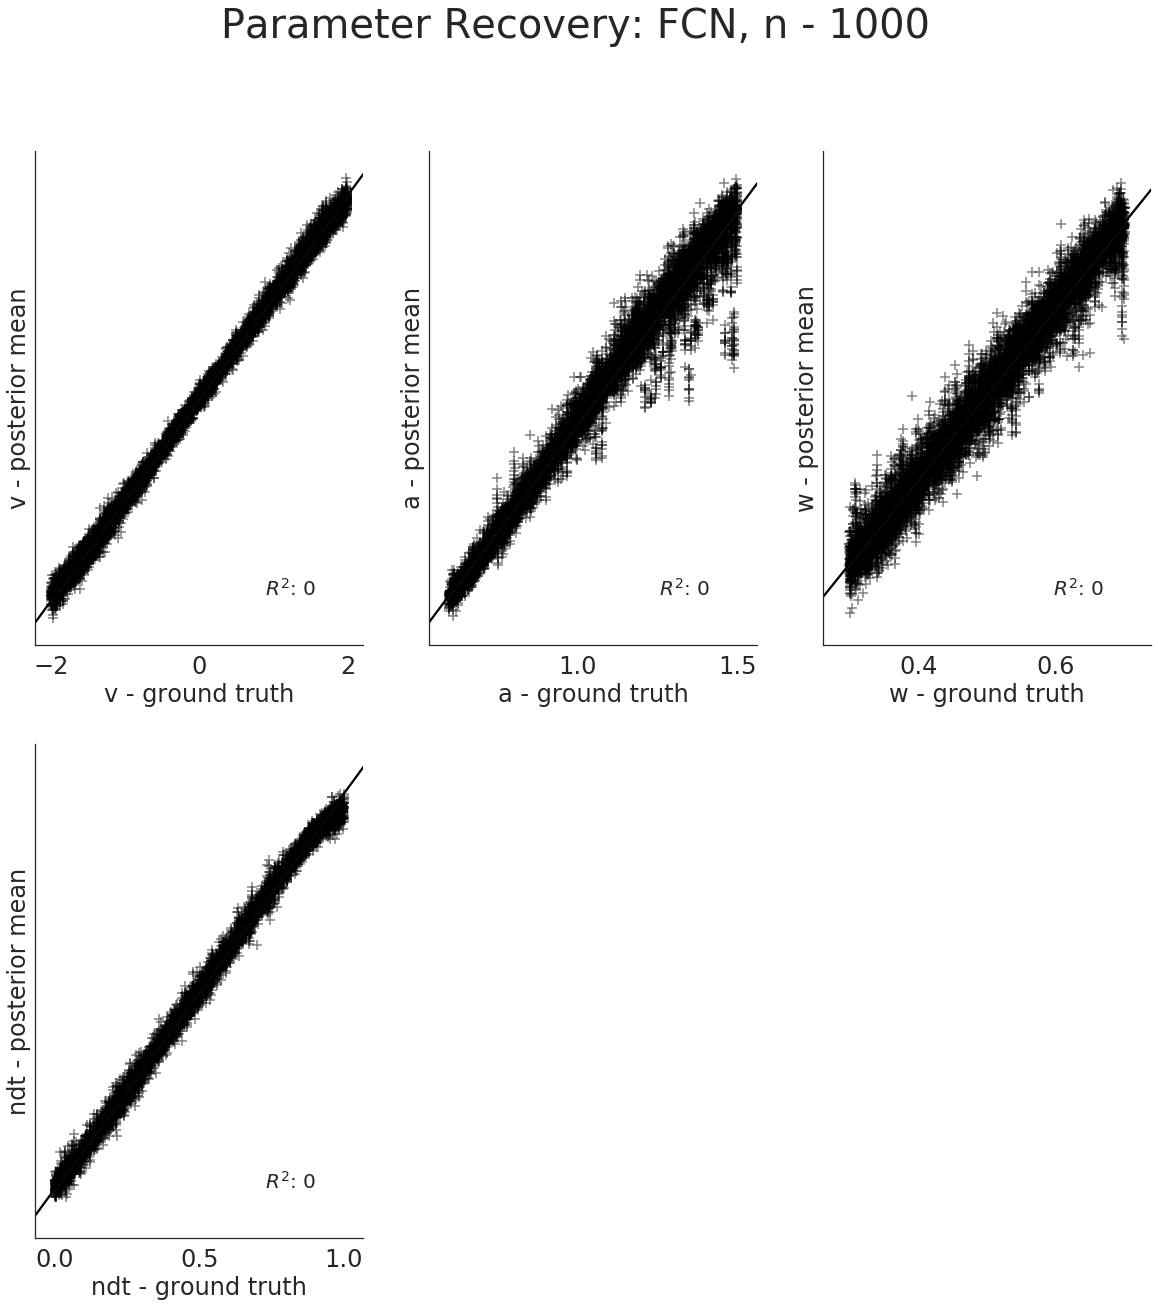

In [63]:
# PARAMETER RECOVERY PLOTS: KDE
i = 1
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt'],
                        title = 'Parameter Recovery: FCN, n - ' + str(dat_total[i][1].shape[1]),
                        ground_truths = dat_total[i][0],
                        estimates = dat_total[i][2][:, :int(dat_total[i][2].shape[1] / 2)],
                        r2_vec = [str(0), str(0), str(0), str(0)],
                        cols = 3)

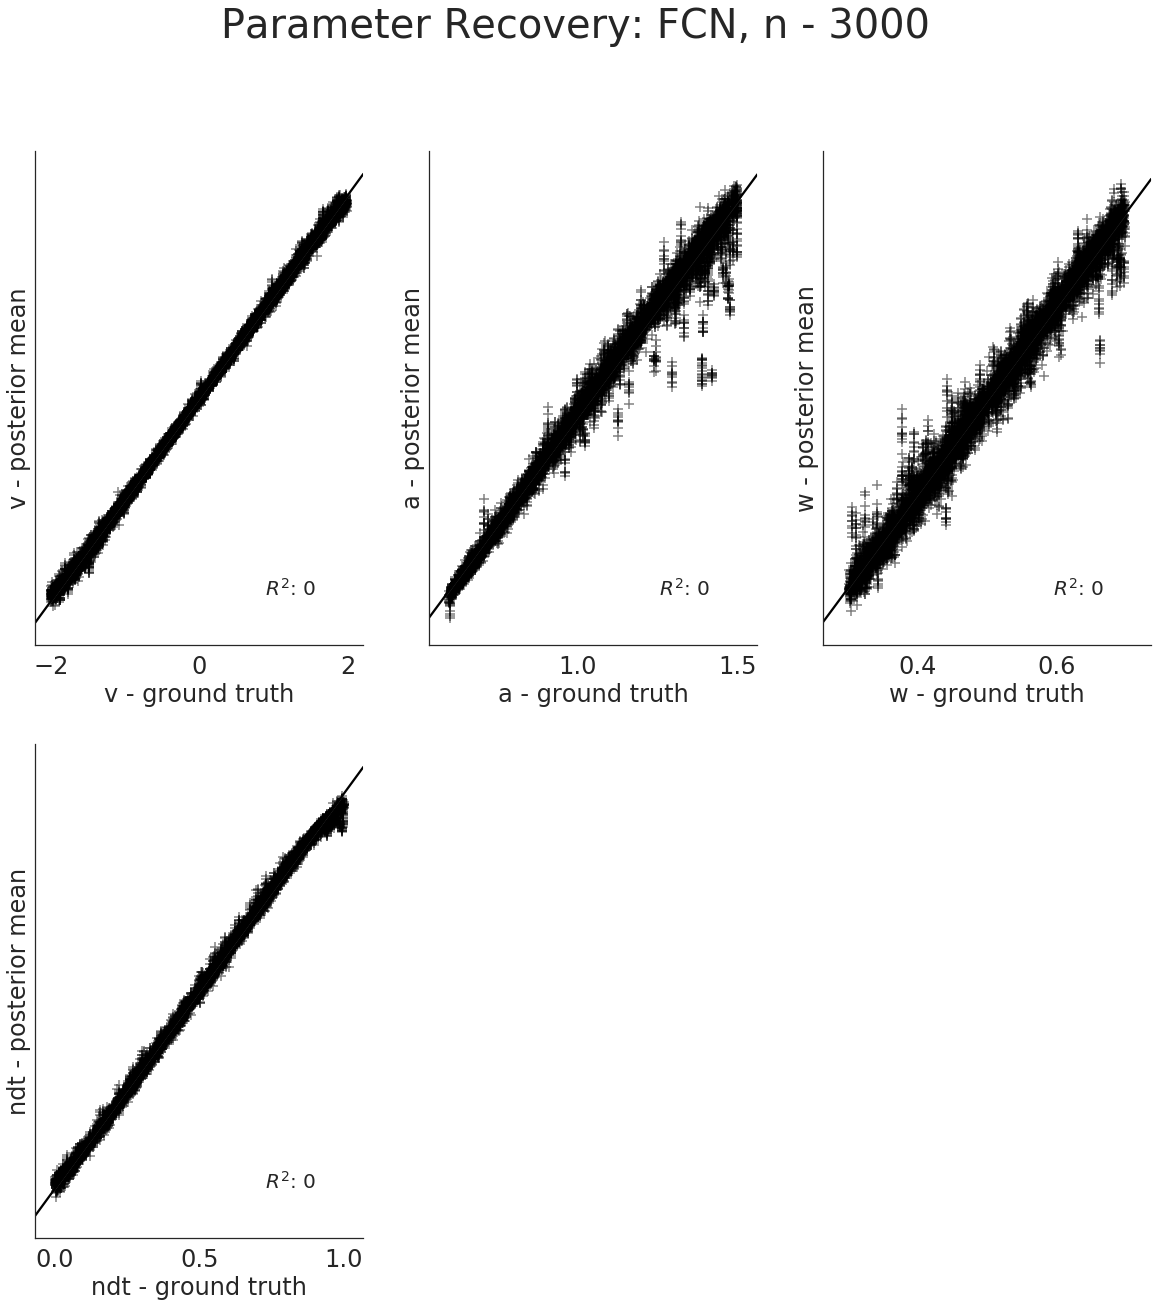

In [64]:
# PARAMETER RECOVERY PLOTS: KDE
i = 2
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt'],
                        title = 'Parameter Recovery: FCN, n - ' + str(dat_total[i][1].shape[1]),
                        ground_truths = dat_total[i][0],
                        estimates = dat_total[i][2][:, :int(dat_total[i][2].shape[1] / 2)],
                        r2_vec = [str(0), str(0), str(0), str(0)],
                        cols = 3)

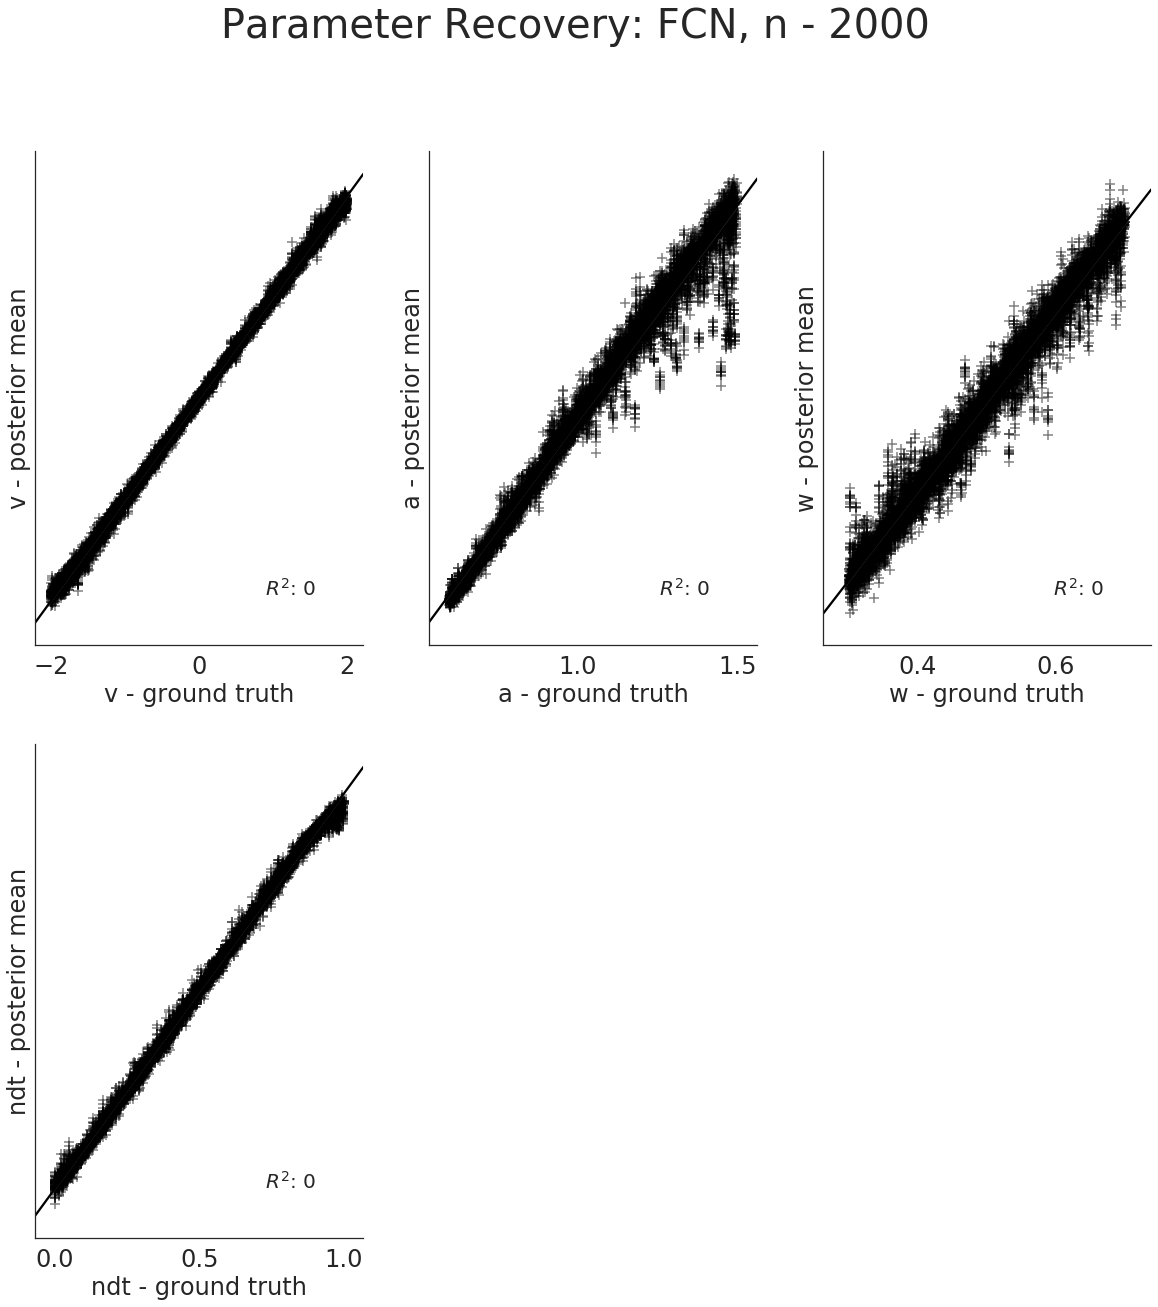

In [65]:
# PARAMETER RECOVERY PLOTS: KDE
i = 3
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt'],
                        title = 'Parameter Recovery: FCN, n - ' + str(dat_total[i][1].shape[1]),
                        ground_truths = dat_total[i][0],
                        estimates = dat_total[i][2][:, :int(dat_total[i][2].shape[1] / 2)],
                        r2_vec = [str(0), str(0), str(0), str(0)],
                        cols = 3)

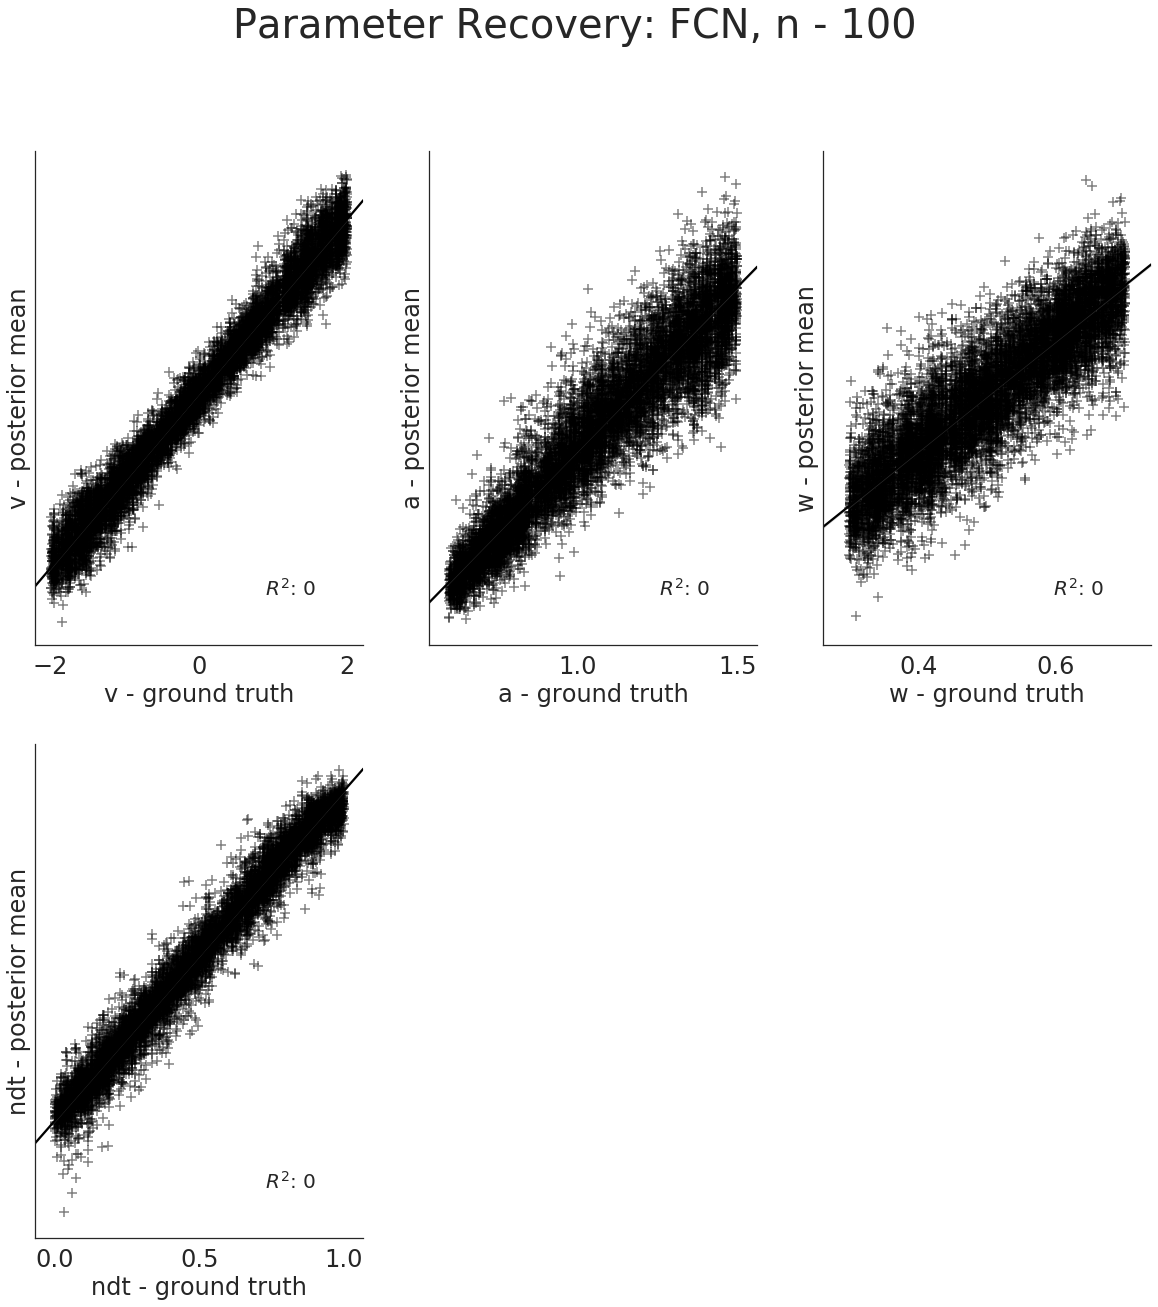

In [66]:
# PARAMETER RECOVERY PLOTS: KDE
i = 4
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt'],
                        title = 'Parameter Recovery: FCN, n - ' + str(dat_total[i][1].shape[1]),
                        ground_truths = dat_total[i][0],
                        estimates = dat_total[i][2][:, :int(dat_total[i][2].shape[1] / 2)],
                        r2_vec = [str(0), str(0), str(0), str(0)],
                        cols = 3)

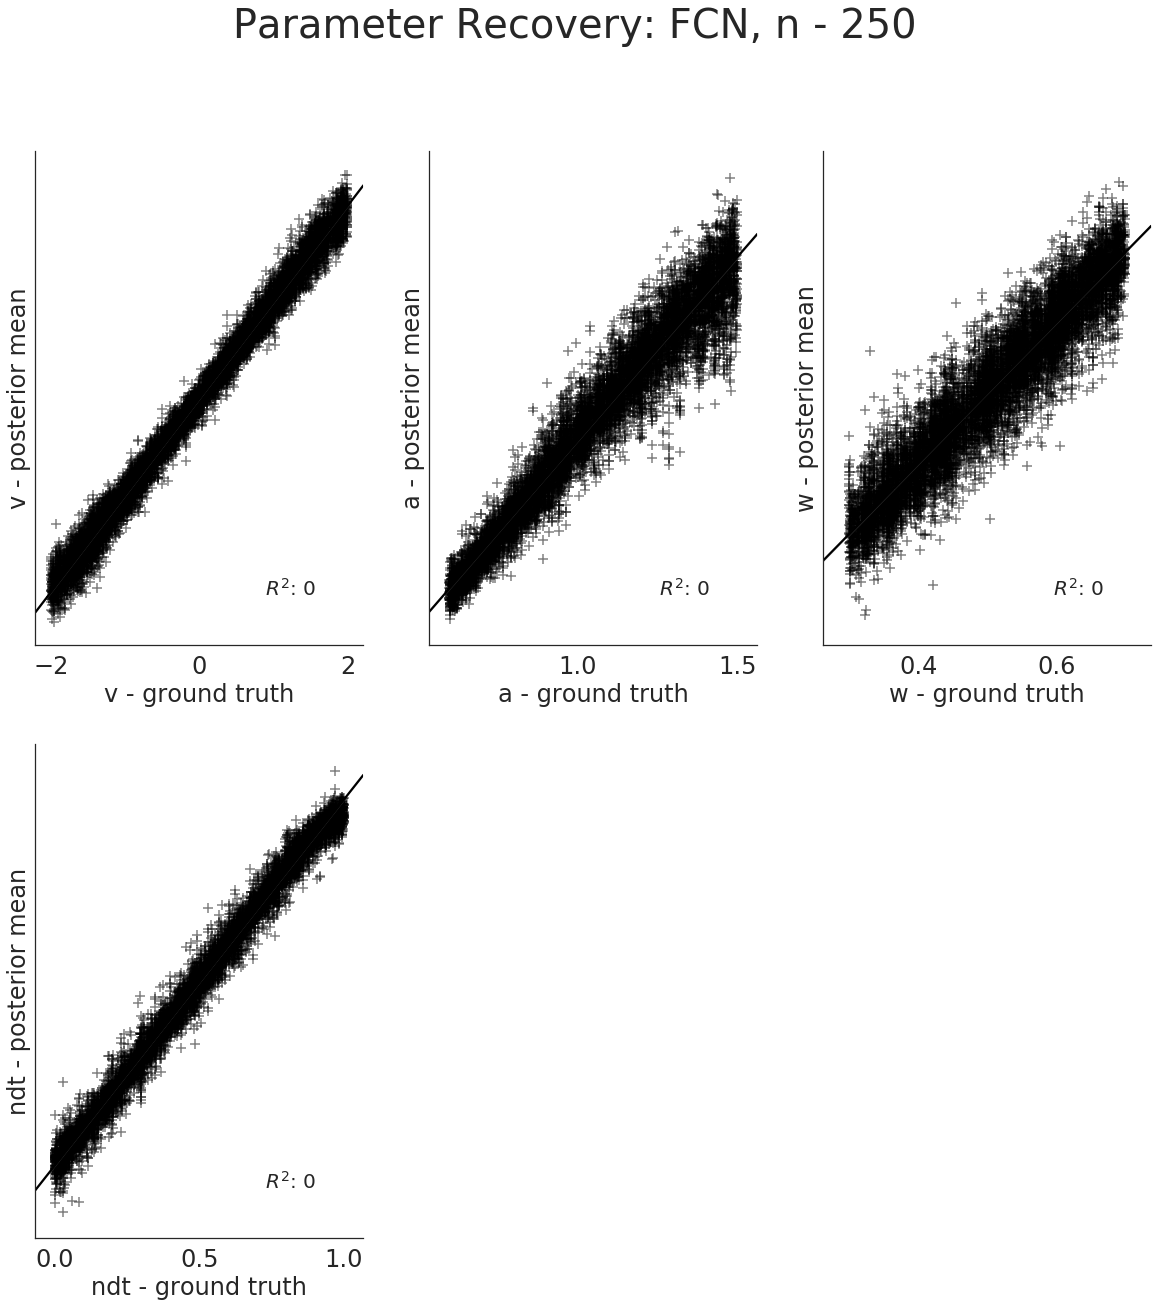

In [67]:
# PARAMETER RECOVERY PLOTS: KDE
i = 5
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt'],
                        title = 'Parameter Recovery: FCN, n - ' + str(dat_total[i][1].shape[1]),
                        ground_truths = dat_total[i][0],
                        estimates = dat_total[i][2][:, :int(dat_total[i][2].shape[1] / 2)],
                        r2_vec = [str(0), str(0), str(0), str(0)],
                        cols = 3)

([array([   0., 1337., 3670., 3452., 1525.,   16.,    0.,    0.,    0.,
            0.]),
  array([4218., 3605.,  903.,  480.,  310.,  225.,  167.,   66.,   18.,
            8.]),
  array([7543., 2384.,   73.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.]),
  array([8785., 1195.,   20.,    0.,    0.,    0.,    0.,    0.,    0.,
            0.])],
 array([0.0032919 , 0.0190182 , 0.03474449, 0.05047078, 0.06619707,
        0.08192337, 0.09764966, 0.11337595, 0.12910224, 0.14482853,
        0.16055483], dtype=float32),
 <a list of 4 Lists of Patches objects>)

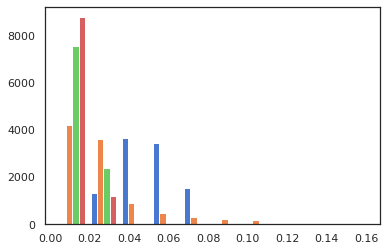

In [68]:
plt.hist(dat_total_var[0])

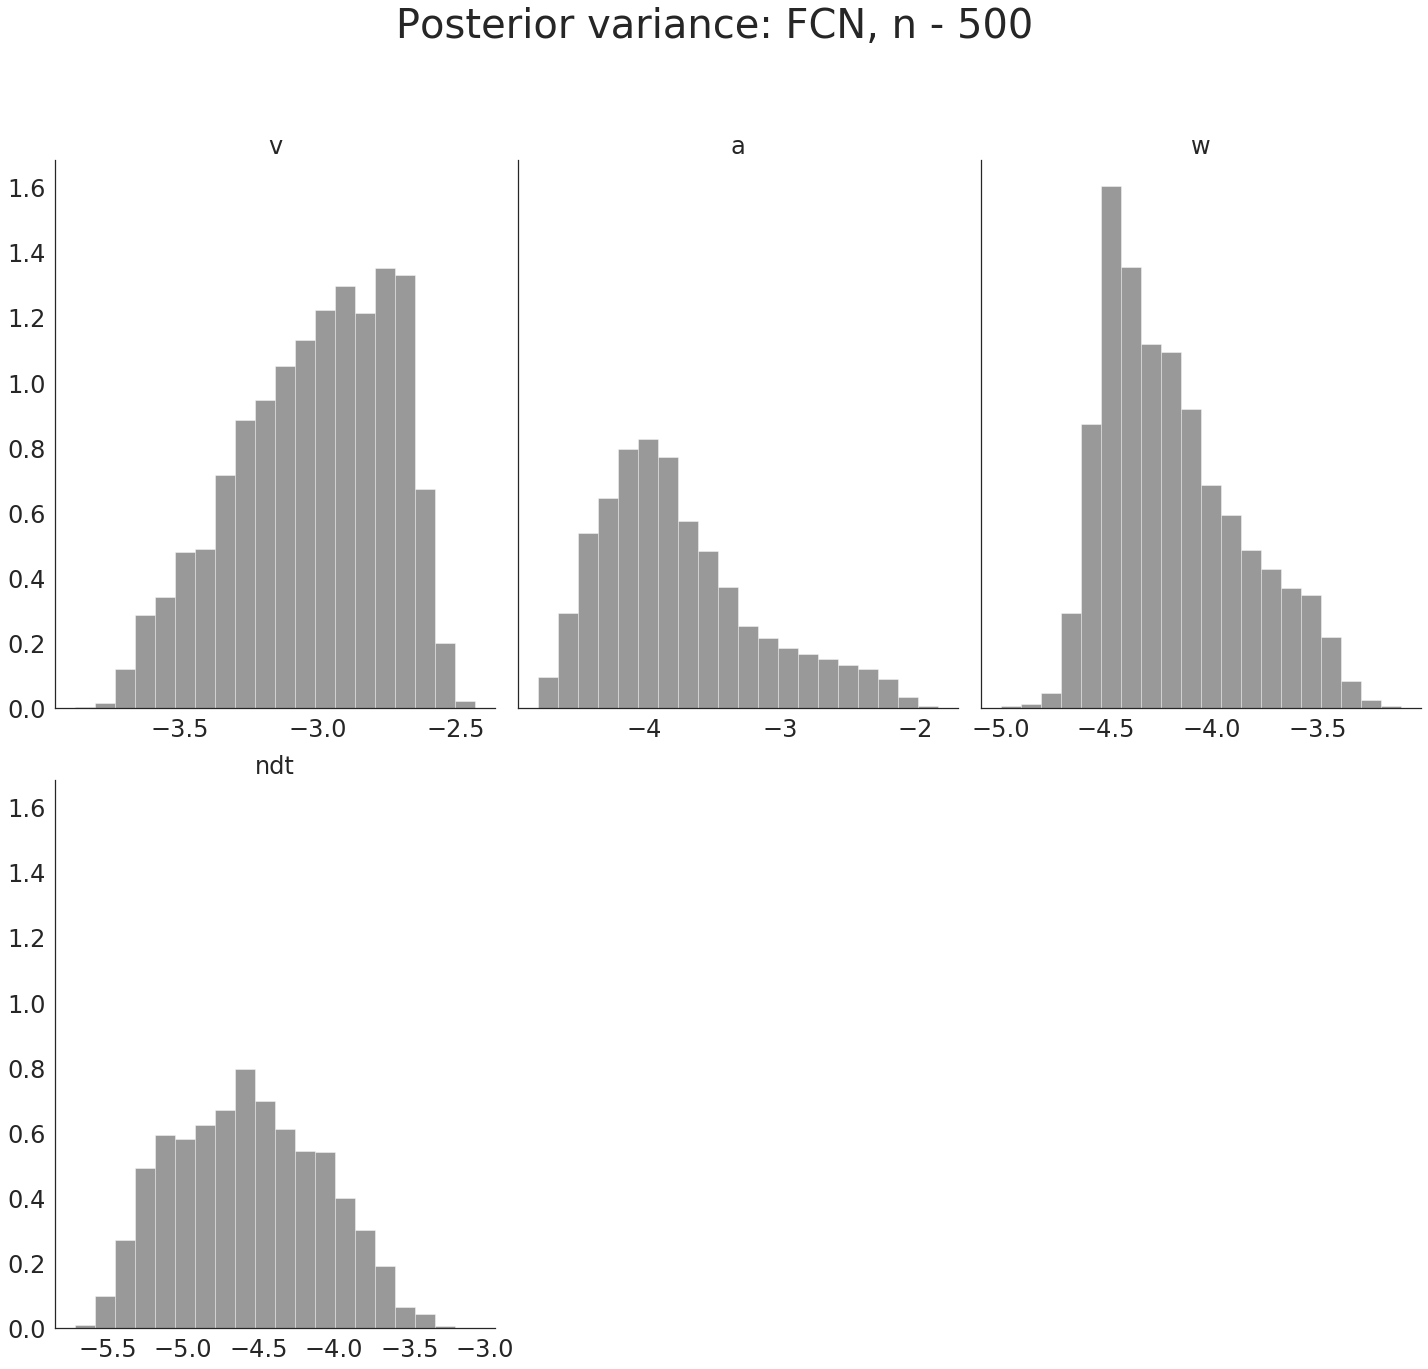

In [72]:
# Variance Histogram
i = 0
posterior_variance_hist(var_data = dat_total_var[i],
                        var_data_title = str(dat_total[i][1].shape[1]),
                        ax_titles = ['v', 'a', 'w', 'ndt'],
                        cols = 3)

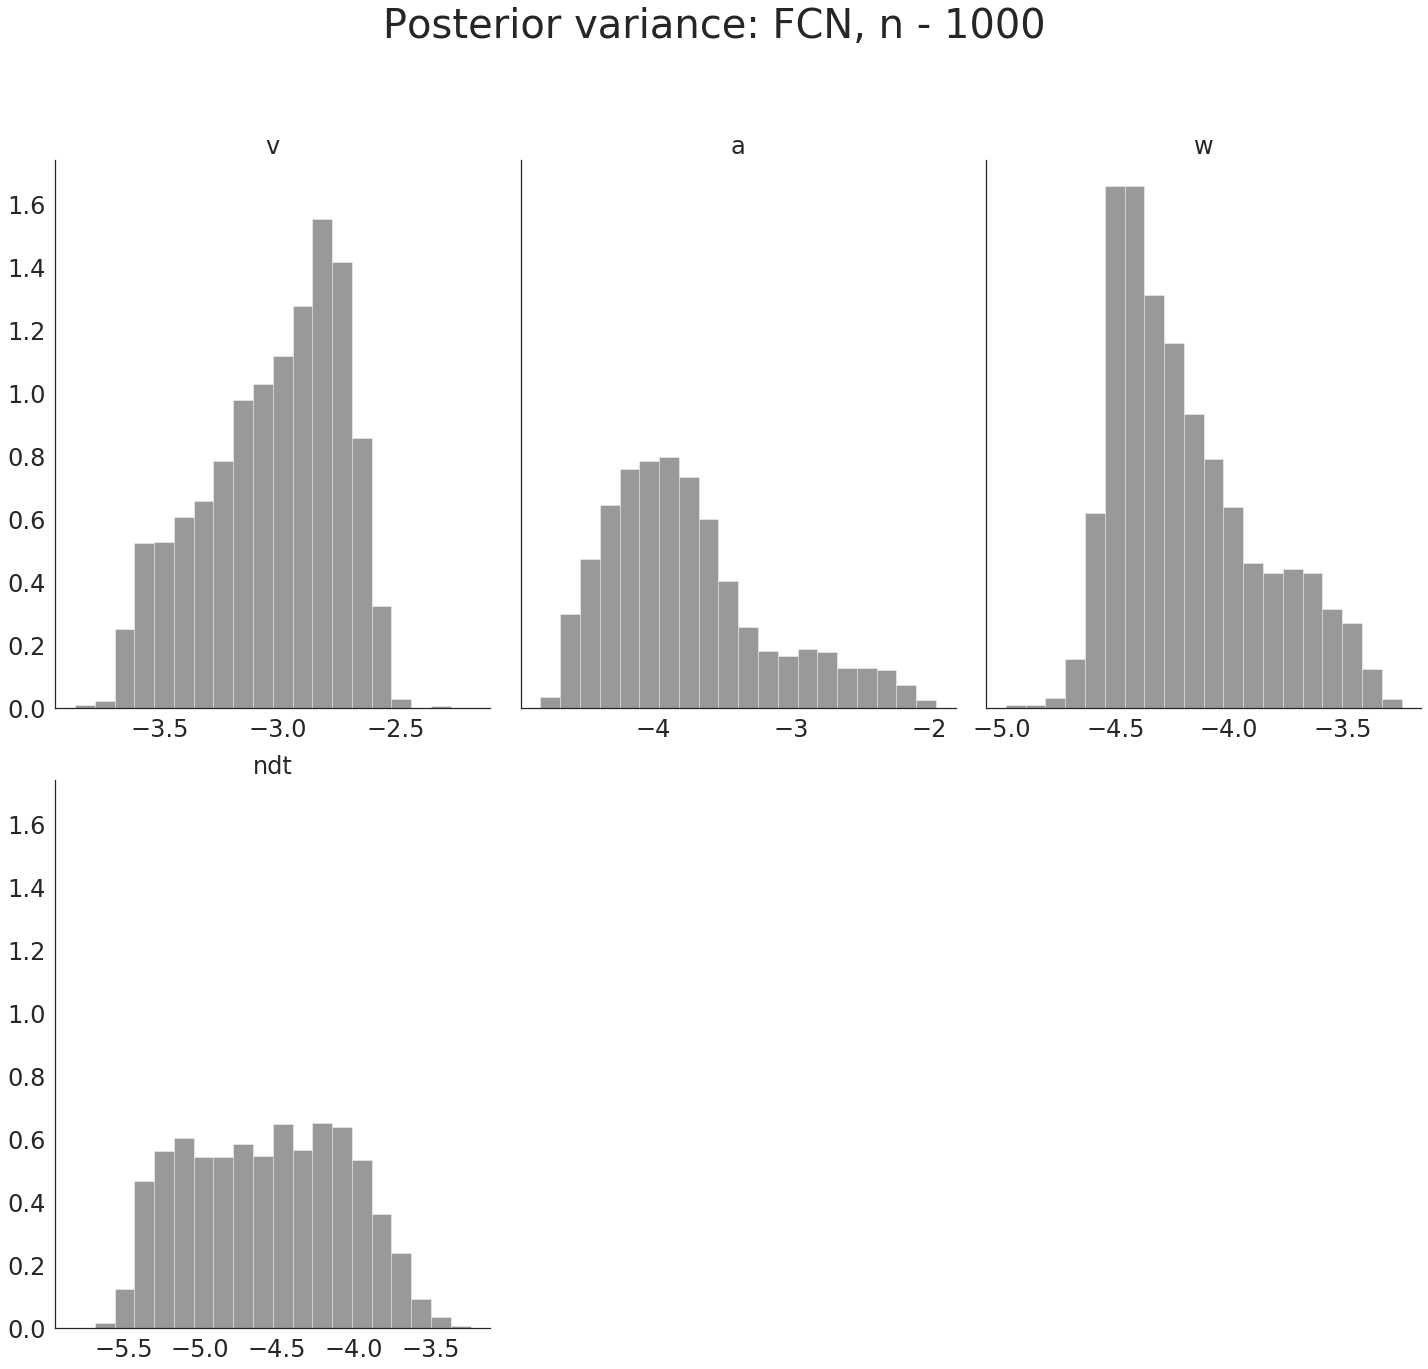

In [73]:
# Variance Histogram
i = 1
posterior_variance_hist(var_data = dat_total_var[i],
                        var_data_title = str(dat_total[i][1].shape[1]),
                        ax_titles = ['v', 'a', 'w', 'ndt'],
                        cols = 3)

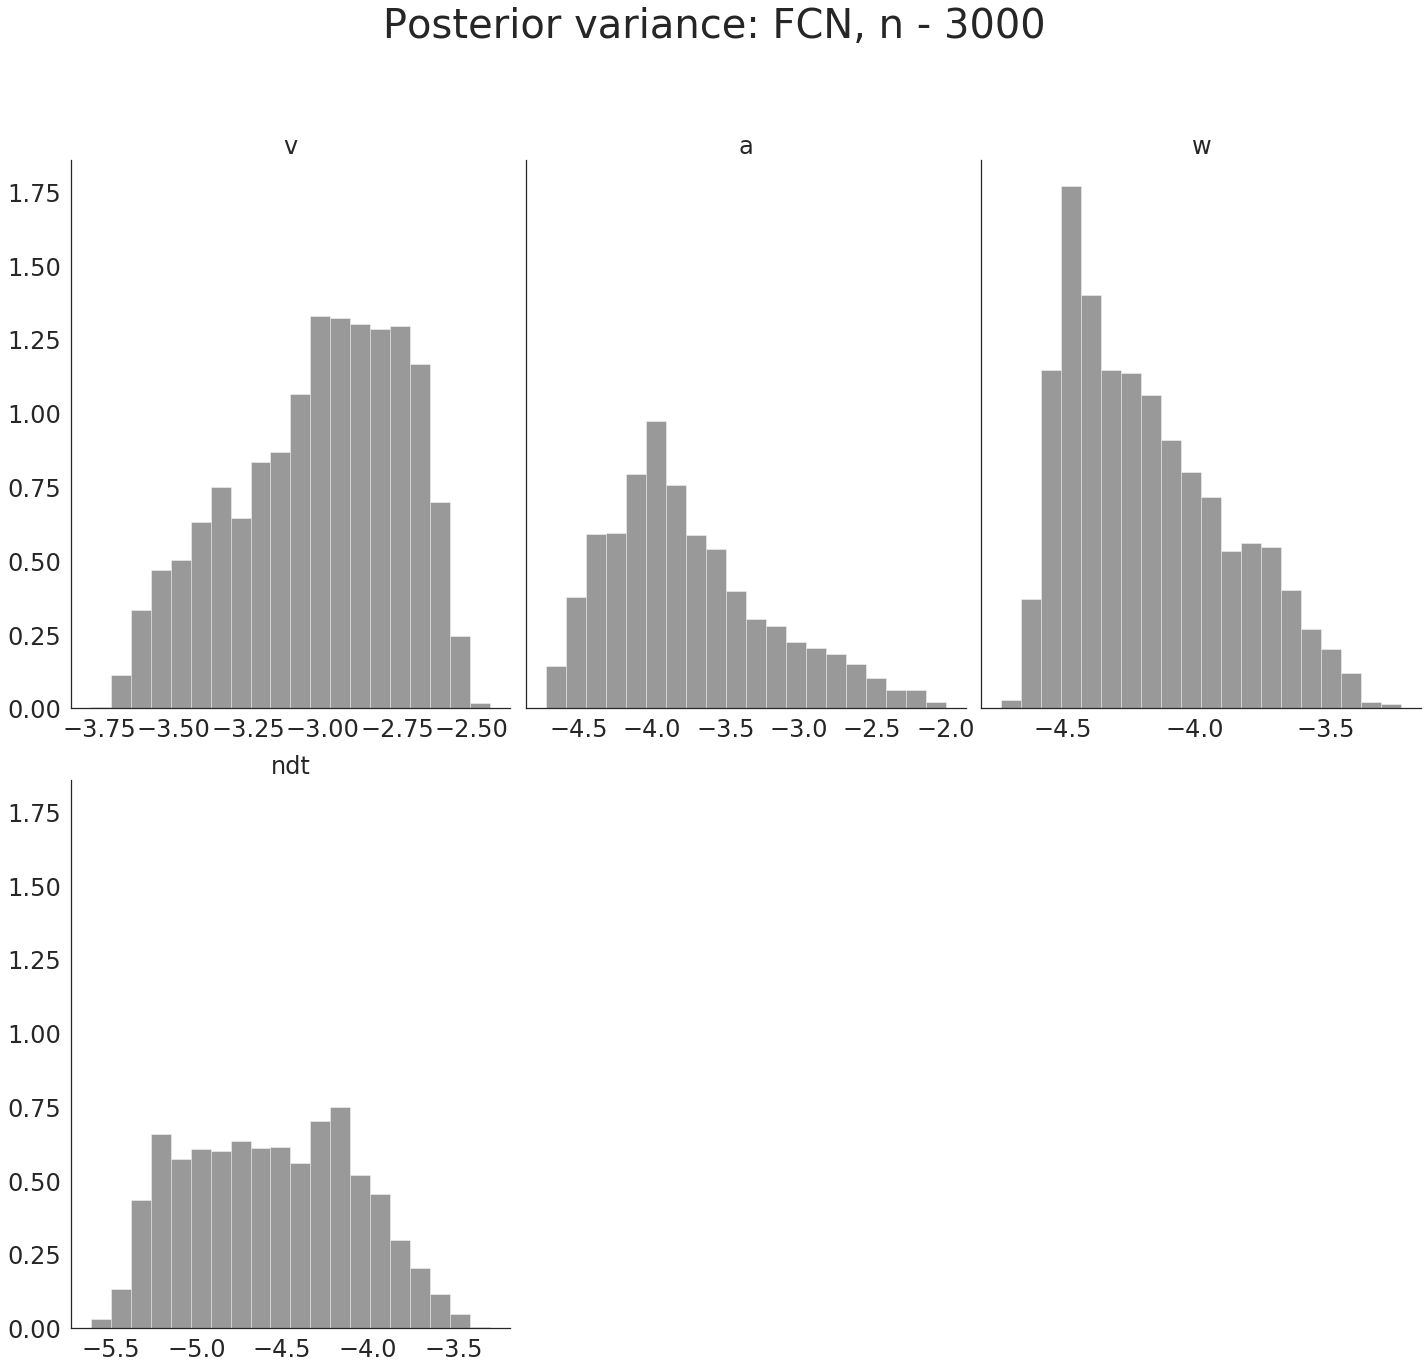

In [74]:
# Variance Histogram
i = 2
posterior_variance_hist(var_data = dat_total_var[i],
                        var_data_title = str(dat_total[i][1].shape[1]),
                        ax_titles = ['v', 'a', 'w', 'ndt'],
                        cols = 3)

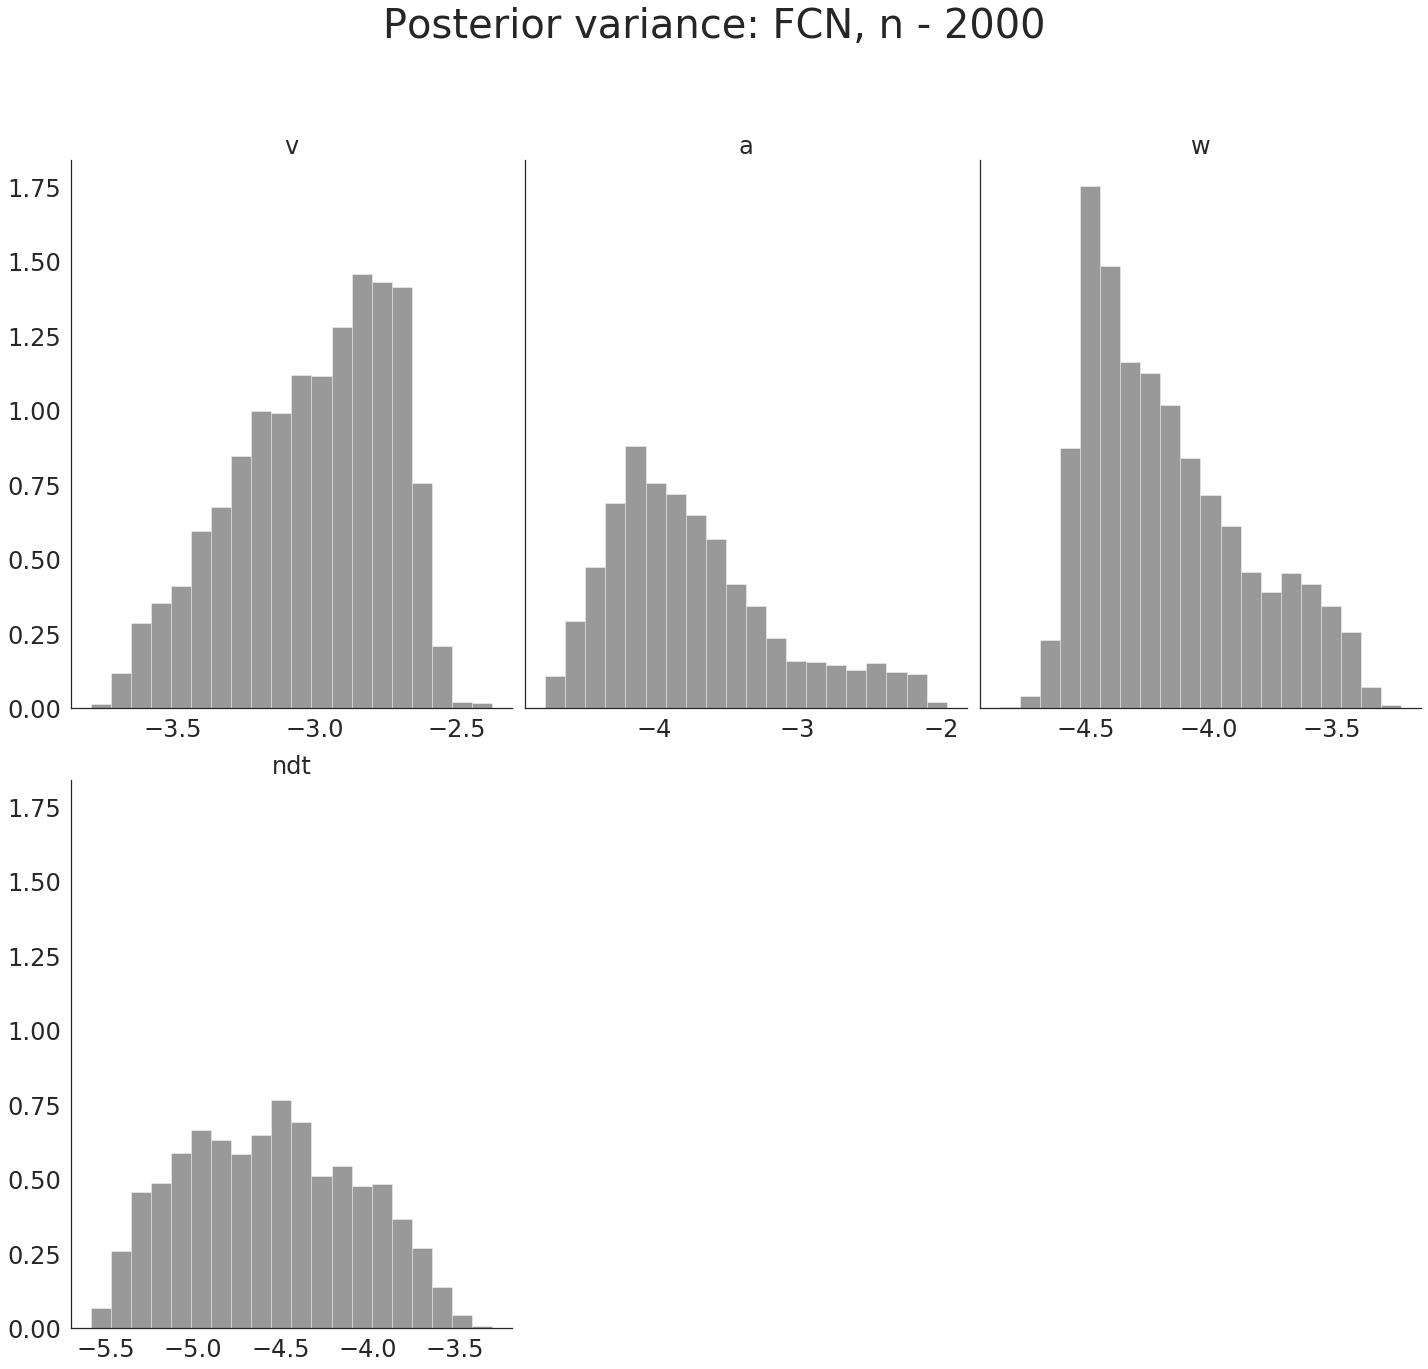

In [75]:
# Variance Histogram
i = 3
posterior_variance_hist(var_data = dat_total_var[i],
                        var_data_title = str(dat_total[i][1].shape[1]),
                        ax_titles = ['v', 'a', 'w', 'ndt'],
                        cols = 3)

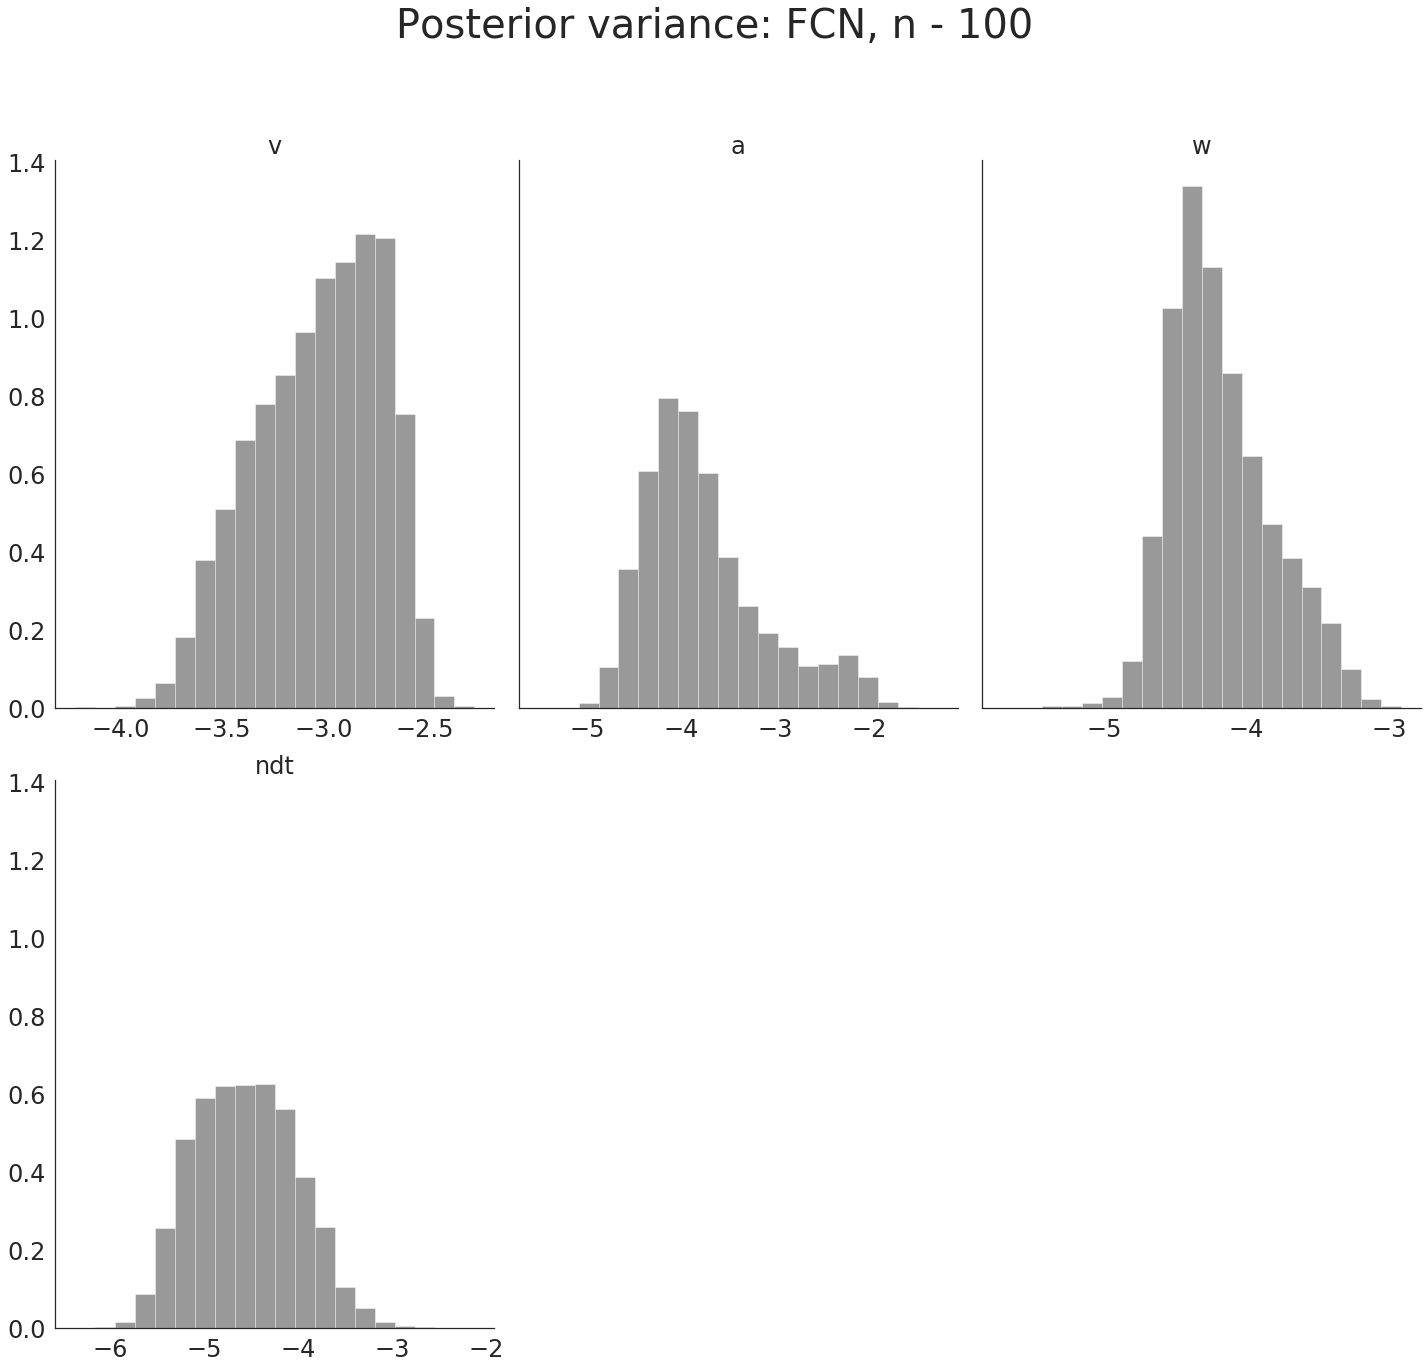

In [76]:
# Variance Histogram
i = 4
posterior_variance_hist(var_data = dat_total_var[i],
                        var_data_title = str(dat_total[i][1].shape[1]),
                        ax_titles = ['v', 'a', 'w', 'ndt'],
                        cols = 3)

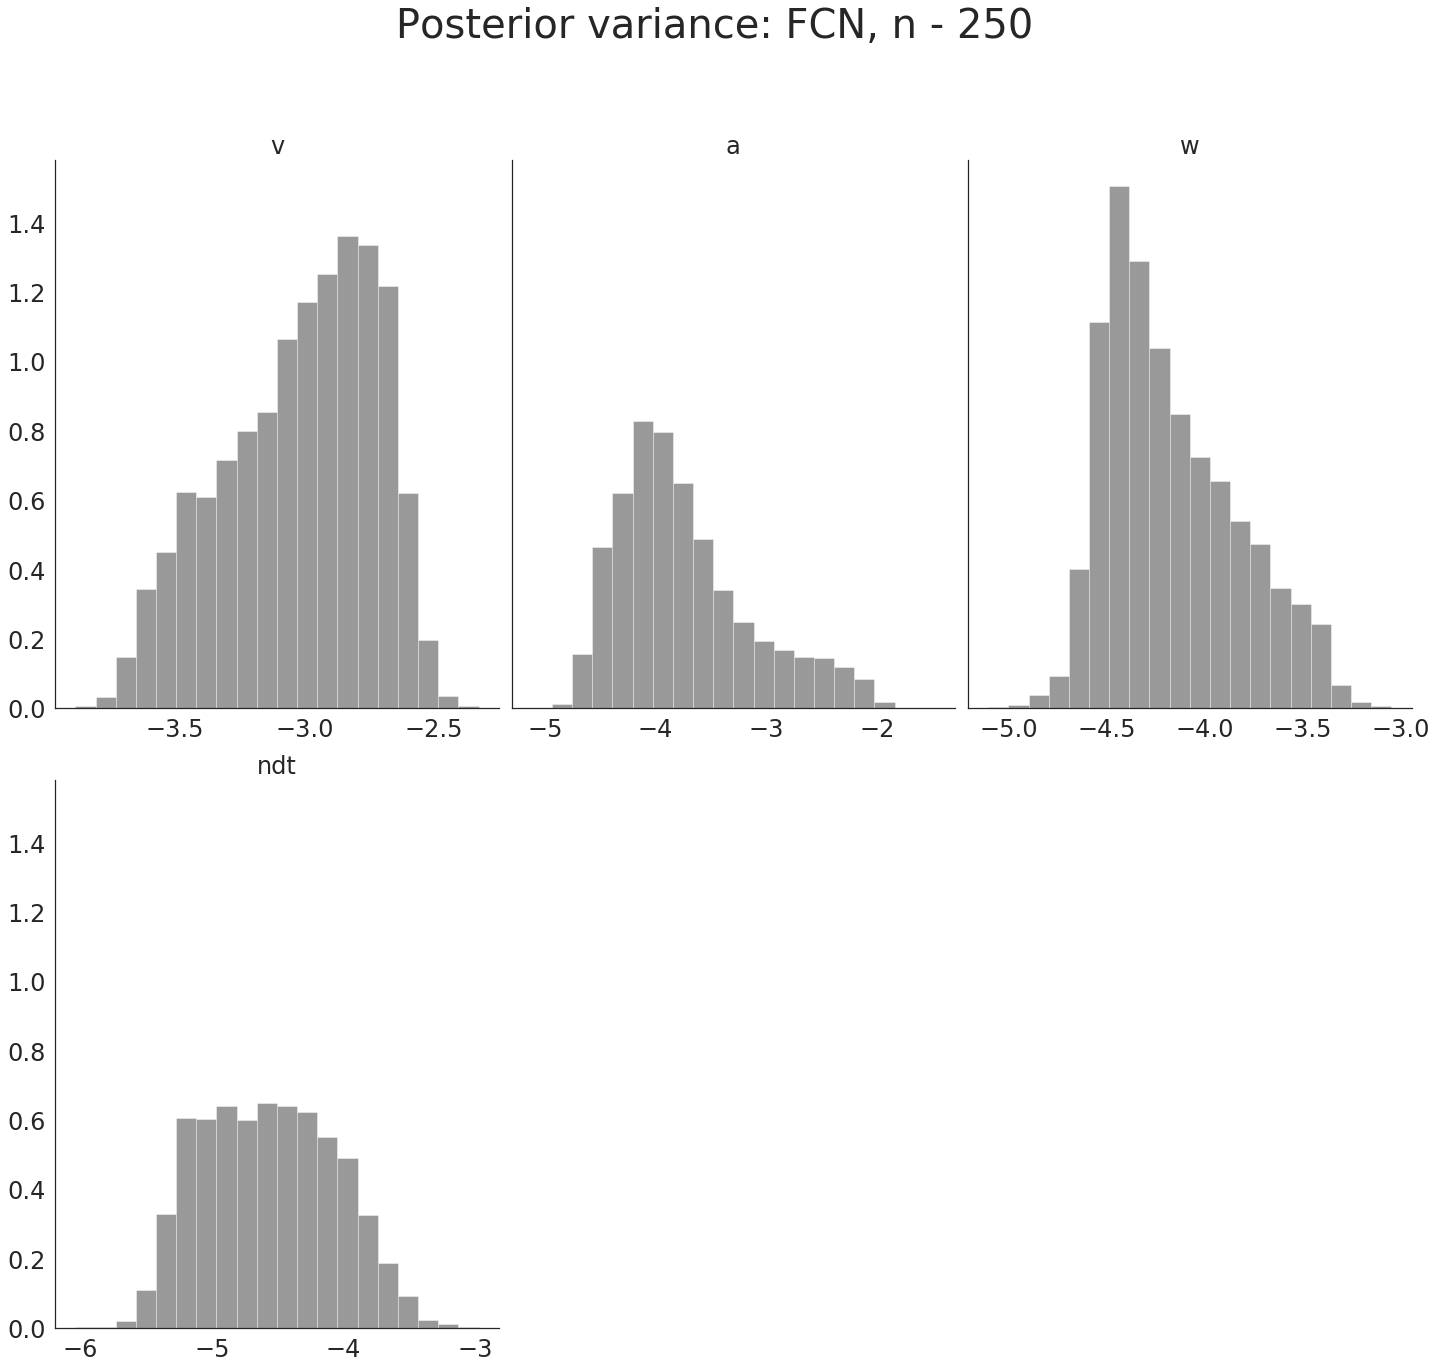

In [77]:
# Variance Histogram
i = 5
posterior_variance_hist(var_data = dat_total_var[i],
                        var_data_title = str(dat_total[i][1].shape[1]),
                        ax_titles = ['v', 'a', 'w', 'ndt'],
                        cols = 3)